somewhere else, do:
```
source $LSSTSW/setup.csh
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -k -r .
setup -t 1898 -r .
setup -t 1898 meas_modelfit
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
w, h = 51, 51

In [2]:
import dipoleTests as dp

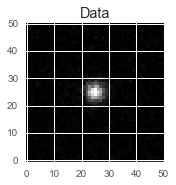

In [4]:
y, x = np.mgrid[:w, :h]
x, y = x.ravel(), y.ravel()
in_x = [x, y]

np.random.seed(666)
z = dp.generateStarImage(in_x, flux=2500., xcen=25., ycen=25., psfWidth=2., sigma2=None, \
                                 ampl2=0.1, afw=False, noise=1.)

plt.figure(figsize=(8, 2.5))
plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray' )
plt.title("Data")

#### OK, now let's look at `lsst.meas.base.tests.TestDataset` for generation of fake data?

Need to do 
```
setup -t b1898 meas_base
```

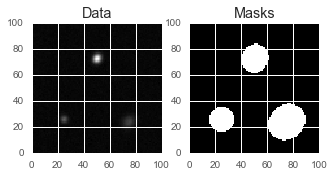

In [5]:
from lsst.meas.base.tests import TestDataset
import lsst.afw.geom as afwGeom

bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(100, 100))
dataset = TestDataset(bbox)
dataset.addSource(flux=1E5, centroid=afwGeom.Point2D(25, 26))
dataset.addSource(flux=2E5, centroid=afwGeom.Point2D(75, 24),
                      shape=afwGeom.ellipses.Quadrupole(8, 7, 2))
with dataset.addBlend() as family:
    family.addChild(flux=2E5, centroid=afwGeom.Point2D(50, 72))
    family.addChild(flux=1.5E5, centroid=afwGeom.Point2D(51, 74))
exposure, catalog = dataset.realize(noise=100.0, schema=TestDataset.makeMinimalSchema())

plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(exposure.getMaskedImage().getArrays()[0], origin='lower', interpolation='none', cmap='gray' )
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(exposure.getMaskedImage().getArrays()[1], origin='lower', interpolation='none', cmap='gray' )
plt.title("Masks")

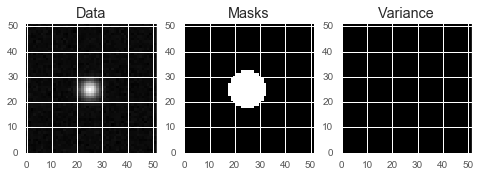

In [6]:
def makeStarImage_lsst():
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(51, 51))
    dataset = TestDataset(bbox)
    dataset.addSource(flux=2500., centroid=afwGeom.Point2D(25, 25), 
                      shape=afwGeom.ellipses.Quadrupole(2., 2., 0.))
    exposure, catalog = dataset.realize(noise=1.0, schema=TestDataset.makeMinimalSchema())
    return exposure, catalog

exposure, catalog = makeStarImage_lsst()
ma = exposure.getMaskedImage().getArrays()
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(ma[0], origin='lower', interpolation='none', cmap='gray' )
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(ma[1], origin='lower', interpolation='none', cmap='gray' )
plt.title("Masks")
plt.subplot(1, 3, 3)
plt.imshow(ma[2], origin='lower', interpolation='none', cmap='gray' )
plt.title("Variance")

The following is taken from `meas_modelfit/tests/testPsfFitter.py`

0 2 1
6.02995191864 6.09049489126 -0.0601747774179
4.71
3917.65915856
((ixx=0.00394960989279, iyy=7.25634762621, ixy=-0.0247606292797), (0.99429, -0.0031309))
((ixx=1.78517932511, iyy=0.018603852796, ixy=0.0429290123892), (-0.35972, 1.8164))
4221.9544911
((ixx=4.93784815816, iyy=0.00575814331303, ixy=0.16741358448), (0.23809, -2.0094))
((ixx=0.00299810768616, iyy=2.65055010423, ixy=0.00252593253624), (-0.0043277, 0.11976))
2138.01466671
((ixx=6.02995191864, iyy=6.09049489126, ixy=-0.0601747774179), (0, 0))
((ixx=24.1198076746, iyy=24.361979565, ixy=-0.240699109672), (0, 0))


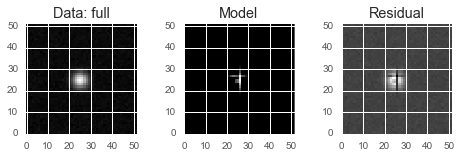

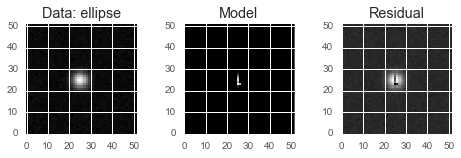

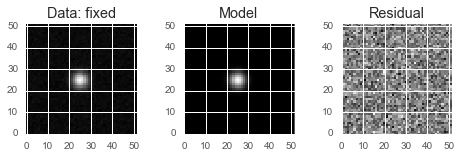

In [15]:
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
import lsst.meas.modelfit as modelFit

ELLIPSE_PARAMETER_NAMES = ["eta1", "eta2", "logR", "x", "y"]

def setupConfigs():
    configs = {}
    configs['fixed'] = modelFit.PsfFitterConfig()
    configs['fixed'].primary.ellipticityPriorSigma = 0.0
    configs['fixed'].primary.radiusPriorSigma = 0.0
    configs['fixed'].primary.positionPriorSigma = 0.0
    configs['fixed'].wings.ellipticityPriorSigma = 0.0
    configs['fixed'].wings.radiusPriorSigma = 0.0
    configs['fixed'].wings.positionPriorSigma = 0.0
    configs['ellipse'] = modelFit.PsfFitterConfig()
    configs['ellipse'].primary.positionPriorSigma = 0.1
    configs['ellipse'].wings.positionPriorSigma = 0.1
    configs['full'] = modelFit.PsfFitterConfig()
    configs['full'].inner.order = 0
    configs['full'].primary.order = 4
    configs['full'].wings.order = 4
    configs['full'].outer.order = 0
    configs['full'].inner.ellipticityPriorSigma = 0.3
    configs['full'].inner.radiusPriorSigma = 0.5
    configs['full'].inner.positionPriorSigma = 0.1
    configs['full'].primary.ellipticityPriorSigma = 0.3
    configs['full'].primary.radiusPriorSigma = 0.5
    configs['full'].primary.positionPriorSigma = 0.1
    configs['full'].wings.ellipticityPriorSigma = 0.3
    configs['full'].wings.radiusPriorSigma = 0.5
    configs['full'].wings.positionPriorSigma = 0.1
    configs['full'].outer.ellipticityPriorSigma = 0.3
    configs['full'].outer.radiusPriorSigma = 0.5
    configs['full'].outer.positionPriorSigma = 0.1
    return configs

def computeMoments(image):
    """Helper function to compute moments of a postage stamp about its origin."""
    maskedImage = image #afwImage.MaskedImageD(image)
    result = measBase.SdssShapeAlgorithm.computeAdaptiveMoments(
        maskedImage,
        afwGeom.Point2D(0, 0)
        )
    return result.getShape()

kernelImage = exposure.getMaskedImage().getImage() ##lsst.afw.image.ImageD(filename)
kernelImage.setXY0(-25, -25)  ## center it on the star

#filename = glob.glob(os.path.join(DATA_DIR, "psfs", "great3*.fits"))[0]
#kernelImage = afwImage.ImageD(filename)

shape = computeMoments(kernelImage)
print shape.IXX, shape.IXY, shape.IYY
print shape.getIxx(), shape.getIyy(), shape.getIxy()
print 2.355*2.  ## sigma -> fwhm

configs = setupConfigs()
tolerances = {"full": 3E-4, "ellipse": 8E-3, "fixed": 1E-2}

for configKey in ["full", "ellipse", "fixed"]:
    fitter = modelFit.PsfFitter(configs[configKey].makeControl())
    #%timeit fitter.apply(kernelImage, shape, 0.1)   ## last param is noiseSigma (see meas_modelfit/src/psf.cc)
    multiShapeletFit = fitter.apply(kernelImage, shape, 0.1)   ## last param is noiseSigma (see meas_modelfit/src/psf.cc)
    modelImage = afwImage.ImageD(kernelImage.getBBox(afwImage.PARENT))
    multiShapeletFit.evaluate().addToImage(modelImage)
    
    print np.abs(kernelImage.getArray() - modelImage.getArray()).sum()
    x = multiShapeletFit.getComponents()
    print x[0].getEllipse()
    print x[1].getEllipse()
    
    plt.figure(figsize=(8, 2.0))
    plt.subplot(1, 3, 1)
    plt.imshow(kernelImage.getArray(), origin='lower', interpolation='none', cmap='gray' )
    plt.title("Data: " + configKey)
    plt.subplot(1, 3, 2)
    plt.imshow(modelImage.getArray(), origin='lower', interpolation='none', cmap='gray' )
    plt.title("Model")
    plt.subplot(1, 3, 3)
    plt.imshow(kernelImage.getArray() - modelImage.getArray(), origin='lower', interpolation='none', cmap='gray' )
    plt.title("Residual")
